# Predict House Prices : Regression Example 

The Boston Housing Price dataset :    
* 404 samples for training set 
* 102 samples for test set 
* Different scales between variables

In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Target prices are divided by 1000. Ex: 12.6 = $12 600

### PREPROCESSING :

Normalization -> We need to put all features on the same scale (only on training set to prevent data leakage)

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### BUILD THE MODEL :

As output layer we will use a simple 1-unit Dense layer (which is purely linear) because we want a scalar value. There is no activation because an activation function would constrain the output range of the scalar (ex: sigmoid -> [0,1] | relu -> [0;+inf]...) 

We also use the MSE loss function which is the square of the difference between the predictions and the targets. 

The metric used is the MAE which is the value of the difference. An MAE of 0.5 means off by $500 on average. 

In [7]:
#We use a function here 
def build_model(): 
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) #linear 
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### CROSS-VALIDATION : 

We will use cross validation to evaluate the best parameters of the model (nb of epoch..). We do that because our validation set is too small and might have a high variance by an usual splitting. 

In [13]:
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers

#K-Fold validation 
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [14]:
all_scores

[2.0894229412078857, 2.4447972774505615, 2.487520456314087, 2.3336246013641357]

In [15]:
np.mean(all_scores)

2.3388413190841675

The average is 2.3, it means $2300 off

Let's try with 500 epochs : 

In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model() #build the model already compiled
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)    #verbose=0 train the model in silent mode
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [18]:
average_mae_history

[19.02739143371582,
 15.49230670928955,
 11.300567626953125,
 7.544283390045166,
 5.6592525243759155,
 4.66039776802063,
 4.0557029247283936,
 3.6719531416893005,
 3.484047532081604,
 3.344271421432495,
 3.1829731464385986,
 3.0847936868667603,
 3.047743320465088,
 2.9255276918411255,
 2.8815991282463074,
 2.891932427883148,
 2.7619794607162476,
 2.790791392326355,
 2.7103779315948486,
 2.672324240207672,
 2.634182929992676,
 2.627185583114624,
 2.666213035583496,
 2.5925543308258057,
 2.6134312748908997,
 2.61485093832016,
 2.5998668670654297,
 2.6111193895339966,
 2.6186217069625854,
 2.5465025901794434,
 2.5354349613189697,
 2.569627106189728,
 2.51223224401474,
 2.5715572834014893,
 2.53627473115921,
 2.501278042793274,
 2.456011712551117,
 2.5102668404579163,
 2.4817847311496735,
 2.4273023903369904,
 2.4629247784614563,
 2.4601516127586365,
 2.418660521507263,
 2.493260979652405,
 2.4427736699581146,
 2.456116557121277,
 2.4299665093421936,
 2.470606565475464,
 2.463183730840683,

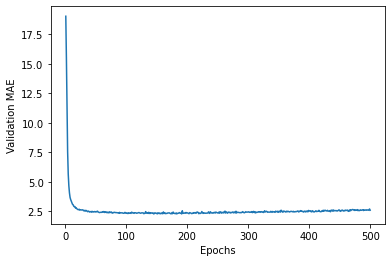

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

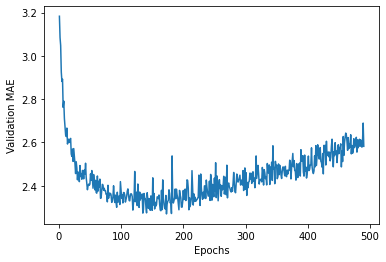

In [22]:
#We use exponential moving average to obtain a smooth curve + delete firt 10 epochs
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()